In [14]:
# 导入数据包
import numpy as np
import pandas as pd
import json
# 加载可视化包
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# 加载词云图
from wordcloud import WordCloud
import re
import nltk
import matplotlib.image as mpimg
# 更改字体
plt.rcParams['font.sans-serif'] = ['SimHei']#更改字体
plt.rcParams['axes.unicode_minus'] = False

In [15]:
# 读取演员列表信息和电影列表信息数据
import pandas as pd
tmdb_credits = pd.read_csv('F:/AI/AI Big Data/Big Data/DATA/Total Exercises/tmdb-5000-movie-dataset/tmdb_5000_credits.csv',encoding='utf_8')
tmdb_moives = pd.read_csv('F:/AI/AI Big Data/Big Data/DATA/Total Exercises/tmdb-5000-movie-dataset/tmdb_5000_movies.csv',encoding='utf_8')
total_movies = pd.concat([tmdb_credits.drop(['title'],axis=1),tmdb_moives],axis=1)
print('两原始数据集合并后有{}个样本，{}个特征！'.format(total_movies.shape[0],total_movies.shape[1]))

两原始数据集合并后有4803个样本，23个特征！


In [16]:
#剔除掉用不上的特征，包括电影ID，电影主页，标语，剧情简介！
movies = total_movies.drop(['movie_id','homepage','id','overview',
                            'tagline','crew','status','original_title'],axis=1)

In [17]:
# 对特征值为json格式的数据转换
movies[['cast','genres','production_countries','production_companies','spoken_languages','keywords']] = \
movies[['cast','genres','production_countries','production_companies','spoken_languages','keywords']].applymap(json.loads)

In [18]:
#检查数据中缺失值，以及缺失值的处理
na_feature = movies.isnull().sum(axis=0)[movies.isnull().sum(axis=0) != 0]
print('哪些属性中有缺失值，以及相应缺失数量：\n',na_feature)
#缺失数据不多，可以相应网上找到这些缺失数据的相关信息
print('上映时间有缺失值的电影名为：',movies[movies['release_date'].isnull()]['title'].values[0])
movies['release_date'].fillna('2014-06-01',inplace=True)
print('放映时间有缺失值的电影名为：',','.join(movies[movies['runtime'].isnull()]['title'].values))
movies['runtime'].fillna(pd.Series([94,81],index=movies[movies['runtime'].isnull()].index),inplace=True)#上映时间缺失值处理
'''
输出：
哪些属性中有缺失值，以及相应缺失数量：
release_date    1
runtime         2
dtype: int64
上映时间有缺失值的电影名为： America Is Still the Place
放映时间有缺失值的电影名为： Chiamatemi Francesco - Il Papa della gente,To Be Frank, Sinatra at 100
'''

哪些属性中有缺失值，以及相应缺失数量：
 release_date    1
runtime         2
dtype: int64
上映时间有缺失值的电影名为： America Is Still the Place
放映时间有缺失值的电影名为： Chiamatemi Francesco - Il Papa della gente,To Be Frank, Sinatra at 100


'\n输出：\n哪些属性中有缺失值，以及相应缺失数量：\nrelease_date    1\nruntime         2\ndtype: int64\n上映时间有缺失值的电影名为： America Is Still the Place\n放映时间有缺失值的电影名为： Chiamatemi Francesco - Il Papa della gente,To Be Frank, Sinatra at 100\n'

In [19]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 15 columns):
cast                    4803 non-null object
budget                  4803 non-null int64
genres                  4803 non-null object
keywords                4803 non-null object
original_language       4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4803 non-null object
revenue                 4803 non-null int64
runtime                 4803 non-null float64
spoken_languages        4803 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
dtypes: float64(3), int64(3), object(9)
memory usage: 562.9+ KB


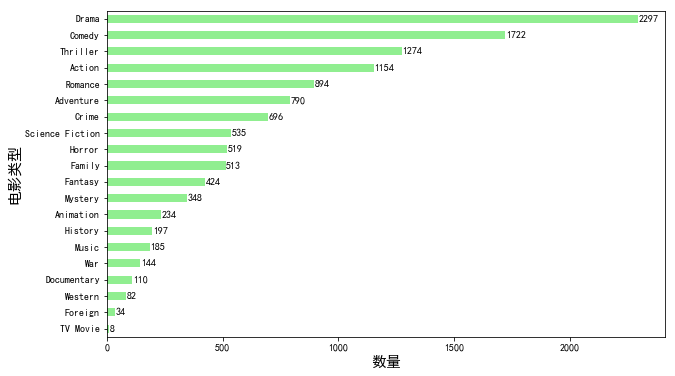

In [20]:
def value_extraction(data):
    '''
    该函数用来提取字典中需要的数据
    '''
    if len([i['name'] for i in data]):
        return [i['name'] for i in data]
    else:
        return np.nan
movies[['cast','genres','production_countries','production_companies','spoken_languages','keywords']] = \
movies[['cast','genres','production_countries',
        'production_companies','spoken_languages','keywords']].applymap(value_extraction)
#有多少种题材的电影
genres_kinds = set()
for row in movies['genres'][movies['genres'].notnull()].values:
    for genres in row:
        genres_kinds.add(genres)
genres_kinds = list(genres_kinds)   
#每个电影属于哪个题材向量化
for genres in genres_kinds:
    movies[genres] = movies['genres'][movies['genres'].notnull()].map(lambda x: 1 if genres in x else 0)
#提取每个电影上映的年限
movies['release_year'] = pd.to_datetime(movies['release_date']).dt.year
movies[[i for i in genres_kinds]].sum().sort_values(ascending=True).plot.barh(figsize=(10,6),fontsize=10,color='lightgreen')
plt.xlabel('数量',fontsize=15)
plt.ylabel('电影类型',fontsize=15)
for x,y in enumerate(movies[[i for i in genres_kinds]].sum().sort_values(ascending=True)):
    plt.text(y+3,x,'{}'.format(int(y)),va='center')
plt.show()

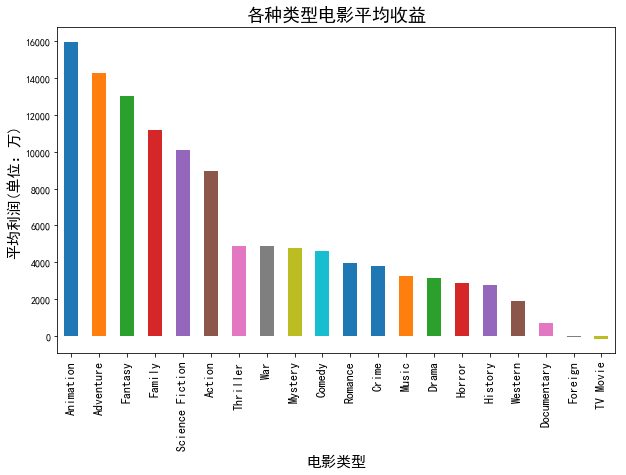

In [21]:
import pandas as pd
profit_genres = []
for genres in genres_kinds:
    revenue = movies[movies[genres]==1].groupby(genres)['revenue'].mean().values[0]
    budget = movies[movies[genres]==1].groupby(genres)['budget'].mean().values[0]
    profit = revenue - budget
    profit_genres.append([genres,profit])
profit_genres_df = pd.Series([i[1] /10000 for i in profit_genres],index=[i[0] for i in profit_genres])
profit_genres_df.sort_values(ascending=False).plot.bar(figsize=(10, 6))
plt.ylabel('平均利润(单位：万)',fontsize=15)
plt.xlabel('电影类型',fontsize=15)
plt.xticks(fontsize=12)
plt.title('各种类型电影平均收益',fontsize=18)
plt.show()
# 虽然市场上comedy, drama, thriller类型最多, 但是这些题材电影不是最赚钱的
# 如果是投资拍电影的话, Animation、Adventure、Fantasy这些类型的电影最赚钱

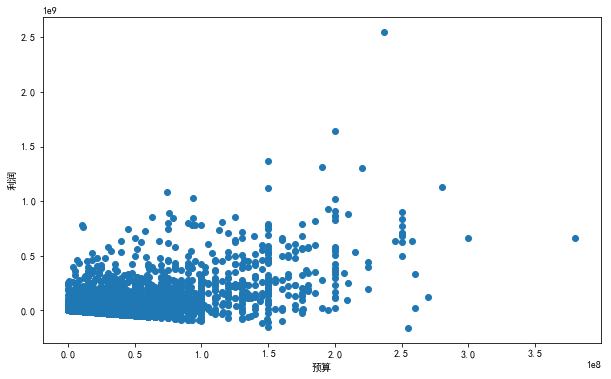

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(movies['budget'],movies['revenue'] - movies['budget'])
plt.xlabel('预算')
plt.ylabel('利润')
plt.show()
# 投资和利润之间的线性关系不是特别明显，不能代表投资和越大收益就越大

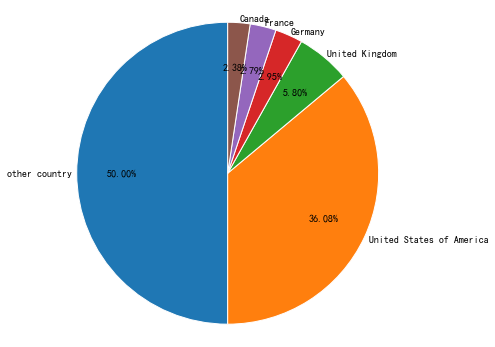

In [23]:
all_countries = set()
for row in movies['production_countries'][movies['production_countries'].notnull()]:
    for country in row:
        all_countries.add(country)
all_countries = list(all_countries)
for country in all_countries:
    movies[country] = movies['production_countries']\
    [movies['production_countries'].notnull()].map(lambda x: 1 if country in x else 0)
    
rank_10_before = movies[[i for i in all_countries]].sum().sort_values(ascending=False)[:5]
rank_10_after = pd.Series(movies[[i for i in all_countries]].sum().sort_values(ascending=False)[:5].sum(),index=['other country'])
rank_country = pd.concat([rank_10_after,rank_10_before],axis=0)
plt.figure(figsize=(6, 6))
plt.pie(rank_country,autopct='%0.2f%%',labels=rank_country.index,startangle=90,
       wedgeprops={'edgecolor':'w'},pctdistance=0.7,labeldistance=1.03)
plt.axis('equal')
plt.show()
# 美国基本上占据了电影行业绝大部分市场

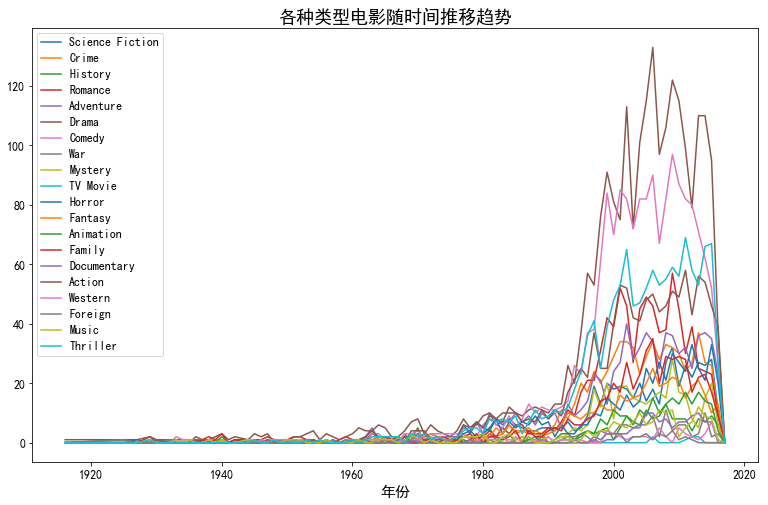

In [24]:
movies.groupby('release_year')[[i for i in genres_kinds]].sum().plot(figsize=(13, 8),fontsize=12)
legend = plt.legend(loc='best')
plt.setp(legend.get_texts(),fontsize=12)
plt.xlabel('年份',fontsize=15)
plt.title('各种类型电影随时间推移趋势',fontsize=18)
plt.show()

In [26]:
from wordcloud import WordCloud
from scipy.misc import imread
mask = imread(r'C:\Users\CW\Desktop\test.png')
wc = WordCloud(background_color='white',max_words=1500,max_font_size=100,mask=mask)
plt.figure(figsize=(15,8))
wc.generate(','.join([j for i in movies['keywords'][movies['keywords'].notnull()] for j in i]))
plt.imshow(wc)
plt.axis('off')
plt.show()

ModuleNotFoundError: No module named 'wordcloud'